In [1]:
import random
import math
import sklearn.tree
import matplotlib.pyplot as plt

## Importing Data Set
Firstly we bring the Car Evaluation Data Set. We need to encode nominal attributes for sklearn.

In [2]:
data_set = []
data_set_labels = []
with open("Car Evaluation Data Set/car.data", "r") as f:
    for line in f.readlines():
        buying, maint, doors, persons, lug_boot, safety, label = line.split(",")
        # Ordinal Encoding
        data_point = [
            ["low", "med", "high", "vhigh"].index(buying),
            ["low", "med", "high", "vhigh"].index(maint),
            ["2", "3", "4", "5more"].index(doors),
            ["2", "4", "more"].index(persons),
            ["small", "med", "big"].index(lug_boot),
            ["low", "med", "high"].index(safety)
        ]
        data_set_labels.append(label)
        data_set.append(data_point)

---

The following functions are auxiliary ones that respectively runs a model on a test set and reports the ratio of wrong predictions and builds a model given a training set.

In [3]:
def test_model(model, test_set, test_set_labels):
    predicted_labels = model.predict(test_set)
    correct_predictions = 0
    n = len(test_set)
    for i in range(len(test_set)):
        if test_set_labels[i] == predicted_labels[i]:
            correct_predictions += 1
    wrong_predictions = n - correct_predictions
    return wrong_predictions / n, wrong_predictions

In [4]:
def build_model(training_set, training_set_labels, **model_options):
    return sklearn.tree.DecisionTreeClassifier(**model_options).fit(training_set, training_set_labels)

---

## Holdout Method
Now we define a new function to randomly partition the data set into training set and test set. The ratio of training set to the data set is passed as an argument.

In [5]:
def holdout_partition(split_ratio):
    data_set_size = len(data_set)
    training_set_size = math.floor(split_ratio * data_set_size)
    training_set_indices = set(random.sample(range(data_set_size), training_set_size))
    training_set = []
    training_set_labels = []
    test_set = []
    test_set_labels = []
    for i in range(data_set_size):
        if i in training_set_indices:
            training_set.append(data_set[i])
            training_set_labels.append(data_set_labels[i])
        else:
            test_set.append(data_set[i])
            test_set_labels.append(data_set_labels[i])
    return training_set, training_set_labels, test_set, test_set_labels

The following function implements the Holdout method by randomly partitioning the whole labeled instances into the data set and test set, building model with leaf nodes upper bound and calculating training and testing errors.

In [6]:
def holdout_method(holdout_split_ratio, **model_options):
    training_set, training_set_labels, test_set, test_set_labels = holdout_partition(holdout_split_ratio)
    model = build_model(training_set, training_set_labels, **model_options)
    training_error, _ = test_model(model, training_set, training_set_labels)
    test_error, _ = test_model(model, test_set, test_set_labels)
    return model, training_error, test_error

In [7]:
def repeated_holdout_method(repeat, holdout_split_ratio, **model_options):
    mean_training_error, mean_test_error = 0, 0
    for j in range(repeat):
        model, training_error, test_error = holdout_method(holdout_split_ratio, **model_options)
        mean_test_error += test_error
        mean_training_error += training_error
    return mean_test_error / repeat, mean_training_error / repeat

The following functions applies the Repeated Holdout Method for a given range of integers as decision tree leaf nodes upper bound and returns training and test errors corresponding to each upper bound.

In [8]:
def prepare_holdout_errors(repeat, holdout_split_ratio, begin_leaf_nodes, end_leaf_nodes):
    training_errors = []
    test_errors = []
    leaf_nodes = []
    for i in range(begin_leaf_nodes, end_leaf_nodes):
        mean_test_error, mean_training_error = repeated_holdout_method(
            repeat, holdout_split_ratio, max_leaf_nodes = i)
        training_errors.append(mean_training_error)
        test_errors.append(mean_test_error)
        leaf_nodes.append(i)
    return training_errors, test_errors, leaf_nodes

---

## $k$-fold Cross Validation Method
The following functions implements the k-fold partitioning of the data set. It randomly samples without replacement $\frac{N}{k}$ indices from the data set for each fold, where $N$ is the number of instances data set and $k$ is the numebr of folds. This helps us answer the first question. The test and training error rates are plotted against the count of leaf nodes at the end of the notebook.

In [9]:
def k_fold_partition(k):
    remaining = data_set.copy()
    remaining_labels = data_set_labels.copy()
    folds = []
    fold_size = math.floor(len(data_set) / k)
    for i in range(k - 1):
        remaining_size = len(remaining)
        fold_indices = set(random.sample(range(remaining_size), fold_size))
        fold = []
        fold_labels = []
        for j in range(remaining_size, -1, -1):
            if j in fold_indices:
                fold.append(remaining[j])
                fold_labels.append(remaining_labels[j])
                del remaining[j], remaining_labels[j]
        folds.append((fold, fold_labels))
    folds.append((remaining, remaining_labels))
    return folds

The following method implements the $k$-fold Cross Validation Method using the $k$-fold partitioning.

In [10]:
def cross_validation_method(k, **model_options):
    folds = k_fold_partition(k)
    total_wrong_predictions = 0
    for i in range(k):
        test_set, test_set_labels = folds[i]
        training_set, training_set_labels = [], []
        for j in range(k):
            if j == i:
                continue
            fold, fold_labels = folds[j]
            training_set.extend(fold)
            training_set_labels.extend(fold_labels)
        model = build_model(training_set, training_set_labels, **model_options)
        error_rate, wrong_predictions = test_model(model, test_set, test_set_labels)
        total_wrong_predictions += wrong_predictions
    return total_wrong_predictions / len(data_set)

The following functions applies the $k$-fold Cross Validation Method for a given range of integers as number of folds and returns generalization error estimate corresponding to each value of $k$.

In [11]:
def prepare_cross_validation_errors(k_begin, k_end, max_leaf_nodes):
    test_errors = []
    optimal_model_errors_on_data_set = []
    fold_counts = range(k_begin, k_end)
    for k in range(k_begin, k_end):
        test_error = cross_validation_method(k, max_leaf_nodes = max_leaf_nodes)
        test_errors.append(test_error) # cross validation test error (average of k folds)
    return fold_counts, test_errors

---

## Plotting

In [12]:
def plot_holdout_errors():
    fig, ax1 = plt.subplots()
    training_errors, test_errors, leaf_nodes = prepare_holdout_errors(
        repeat = 10,
        holdout_split_ratio = 0.8, # ratio of training set to data set used for random paritioning of data set
        begin_leaf_nodes = 2,
        end_leaf_nodes = 100)
    ax1.plot(leaf_nodes, training_errors, label = "training errors")
    ax1.plot(leaf_nodes, test_errors, label = "test errors")
    ax1.legend()
    ax1.set_xlabel("leaf nodes")
    ax1.set_ylabel("error")
    ax1.set_title("Repeated Holdout Method")
    return training_errors, test_errors, leaf_nodes

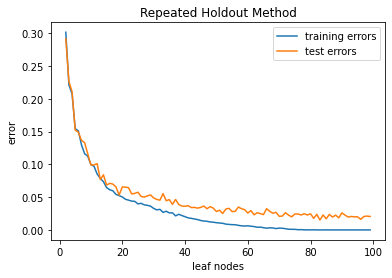

In [13]:
training_errors, test_errors, leaf_nodes = plot_holdout_errors()

As seen in the plot, trees with more than 20 leaf nodes tend to be overfitted. Calculating the corresponding test and training accuracy, we have:

In [14]:
1 - test_errors[leaf_nodes.index(20)], 1 - training_errors[leaf_nodes.index(20)]

(0.934393063583815, 0.9496382054992764)

For the second question we calculate the generalization error estimate using cross validation for different tree depths and take the model with minimum error rate as the optimal one (and its depth as the optimal depth). We consider $k = 5$ as the number of folds for the following calculations.

In [15]:
def plot_cross_validation_erros(k, depth_begin, depth_end):
    errors = []
    min_error = None
    optimal_depth = None
    for depth in range(depth_begin, depth_end):
        error = cross_validation_method(k, max_depth = depth)
        errors.append(error)
        if not optimal_depth or error < min_error:
            optimal_depth = depth
            min_error = error
    fig, ax2 = plt.subplots()
    ax2.plot(range(depth_begin, depth_end), errors, label="cross validation generalization error")
    ax2.set_xlabel("depth")
    ax2.set_ylabel("error")
    ax2.legend()
    ax2.set_title("k-Fold Cross Validation")
    return optimal_depth

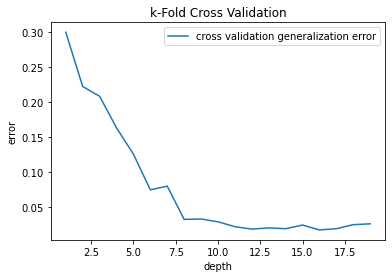

In [16]:
optimal_depth = plot_cross_validation_erros(5, 1, 20)

For the third question, we build a model with the optimal depth and find the test and training error using Repeated Holdout Method.

In [17]:
repeated_holdout_method(repeat = 10, holdout_split_ratio = 0.8, max_depth = optimal_depth)

(0.01936416184971098, 0.0)

Obvisously the test and training errors for this optimal model is significantly smaller than the model with 20 leaf nodes.